First we need to generate the energies at both baseline and target levels.

In [2]:
import mlatom as ml
import numpy as np
import matplotlib.pyplot as plt

# prepare H2 geometries with bond lengths ranging from 0.5 to 5.0 Å
xyz = np.zeros((451, 2, 3))
xyz[:, 1, 2] = np.arange(0.5, 5.01, 0.01)
z = np.ones((451, 2)).astype(int)
molDB = ml.molecular_database.from_numpy(coordinates=xyz, species=z)

# calculate HF energies
hf = ml.models.methods(method='HF/STO-3G', program='PySCF')
hf.predict(molecular_database=molDB, calculate_energy=True)
molDB.add_scalar_properties(molDB.get_properties('energy'), 'HF_energy') # save HF energy with a new name

# calculate CISD energies
cisd = ml.models.methods(method='CISD/cc-pVDZ', program='PySCF')
cisd.predict(molecular_database=molDB, calculate_energy=True)
molDB.add_scalar_properties(molDB.get_properties('energy'), 'FCI_energy')

Here we use HF/STO-3G as the baseline and CISD/cc-pVDZ (FCI in our case) as the target for the geometries with H--H bond lengths ranging from 0.5 to 5.0 Å.

We need to calculate the differences between the target and baseline:

In [3]:
molDB.add_scalar_properties(molDB.get_properties('FCI_energy') - molDB.get_properties('HF_energy'), 'delta_energy')


Now we can train the KREG model on the differences (basically, residual errors)just on the 12 training points (using 10 sub-training and 2 validation points).

In [73]:
# use every 40th point of the data as the training set and split it into the sub-training and validation sets
step = 40
trainDB = molDB[::step]
val = trainDB[::10]
sub = ml.molecular_database([mol for mol in trainDB if mol not in val])
# setup the KREG model
kreg = ml.models.kreg(model_file='KREG.npz', ml_program='KREG_API')
# optimize its hyperparameters
kreg.hyperparameters['sigma'].minval = 2**-5 # modify the default lower bound of the hyperparameter sigma
kreg.optimize_hyperparameters(subtraining_molecular_database=sub,       
                                validation_molecular_database=val,
                                optimization_algorithm='grid',
                                hyperparameters=['lambda', 'sigma'],
                                training_kwargs={'property_to_learn': 'delta_energy', 'prior': 0},
                                prediction_kwargs={'property_to_predict': 'estimated_delta_energy'})
lmbd = kreg.hyperparameters['lambda'].value ; sigma=kreg.hyperparameters['sigma'].value
valloss = kreg.validation_loss
print('Optimized sigma:', sigma)
print('Optimized lambda:', lmbd)
print('Optimized validation loss:', valloss)
# Train the model with the optimized hyperparameters to dump it to disk.
kreg.train(molecular_database=trainDB, property_to_learn='delta_energy')

Optimized sigma: 0.3535533905932738
Optimized lambda: 5.394796609394446e-06
Optimized validation loss: 0.00038082450263702194


After we trained the KREG model, we can use it to estimate the delta corrections for the entire PEC and add them to the baseline predictions to obtain the delta-learning model estimates of the FCI energies:

In [74]:
# predict the delta corrections with the trained KREG model
kreg.predict(molecular_database=molDB, property_to_predict='KREG_delta_energy')
# add them to the baseline values
molDB.add_scalar_properties(molDB.get_properties('HF_energy') + molDB.get_properties('KREG_delta_energy'), 'FCI_energy_est')

Next, let's train the KREG model directly on the FCI data for comparison and use it for predicting the PEC.

In [75]:
# setup the KREG model
kreg_fci = ml.models.kreg(model_file='KREG.npz', ml_program='KREG_API')
# optimize its hyperparameters
kreg_fci.hyperparameters['sigma'].minval = 2**-5 # modify the default lower bound of the hyperparameter sigma
kreg_fci.optimize_hyperparameters(subtraining_molecular_database=sub,       
                                validation_molecular_database=val,
                                optimization_algorithm='grid',
                                hyperparameters=['lambda', 'sigma'],
                                training_kwargs={'property_to_learn': 'FCI_energy', 'prior': 0},
                                prediction_kwargs={'property_to_predict': 'estimated_FCI_energy'})
lmbd = kreg_fci.hyperparameters['lambda'].value ; sigma=kreg_fci.hyperparameters['sigma'].value
valloss = kreg_fci.validation_loss
print('Optimized sigma:', sigma)
print('Optimized lambda:', lmbd)
print('Optimized validation loss:', valloss)
# Train the model with the optimized hyperparameters to dump it to disk.
kreg_fci.train(molecular_database=trainDB, property_to_learn='FCI_energy')
# predict with the direct KREG model
kreg_fci.predict(molecular_database=molDB, property_to_predict='KREG_FCI_energy')

Optimized sigma: 3.9999999999999987
Optimized lambda: 0.04819408829399811
Optimized validation loss: 0.006956885379877074


Finally, let's check the results. 

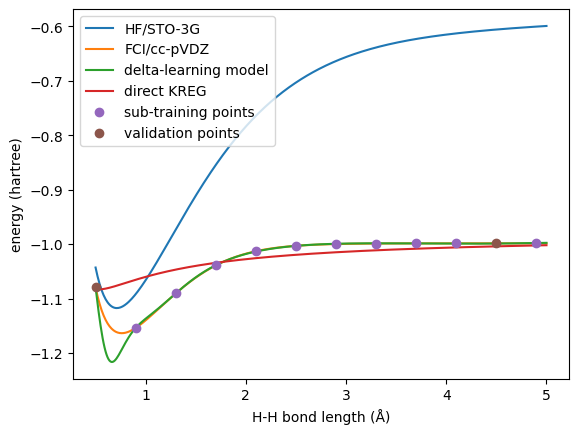

In [76]:
# plot the energies
plt.plot(xyz[:, 1, 2], molDB.get_properties('HF_energy'), label='HF/STO-3G')
plt.plot(xyz[:, 1, 2], molDB.get_properties('FCI_energy'), label='FCI/cc-pVDZ')
# plt.plot(xyz[:, 1, 2], molDB.get_properties('FCI_energy') - molDB.get_properties('HF_energy'), label='delta energy')
# plt.plot(xyz[:, 1, 2], molDB.get_properties('KREG_delta_energy'), label='delta model')
plt.plot(xyz[:, 1, 2], molDB.get_properties('FCI_energy_est'), label='delta-learning model')
plt.plot(xyz[:, 1, 2], molDB.get_properties('KREG_FCI_energy'), label='direct KREG')
plt.plot(sub.xyz_coordinates[:, 1, 2], sub.get_properties('FCI_energy'), 'o', label='sub-training points')
plt.plot(val.xyz_coordinates[:, 1, 2], val.get_properties('FCI_energy'), 'o', label='validation points')
plt.legend()
plt.xlabel('H-H bond length (Å)')
plt.ylabel('energy (hartree)')
plt.show()